## Load DataSet

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.datasets import cifar100
from keras.utils import to_categorical
import numpy as np
import cv2
import os
from keras import backend as K

In [ ]:
(x_train, y_train_), (x_test, y_test_) = cifar100.load_data()


169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

## ResNet18 Model

In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from keras.layers import Conv2D, Input
from keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate
from keras.regularizers import l2
import os

In [ ]:
input_shape = (32, 32, 3)
input = Input(shape=input_shape)
x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=l2(1e-4))(input)
x = BatchNormalization()(x)
x = Activation('elu')(x)

In [ ]:
#Stack 1
for block in range(2):
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)

  x = keras.layers.add([y, x])
  x = Activation('elu')(x)

#Stack 2
for block in range(2):
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=32, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=32, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)
  if block == 0:
    x_2 = Conv2D(kernel_size=1, filters=32, strides=1, padding='same')(x)
  else:
    x_2 = x
  x = keras.layers.add([y, x_2])
  x = Activation('elu')(x)

#Stack 3
for block in range(2):
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)
  if block == 0:
    x_2 = Conv2D(kernel_size=1, filters=64, strides=1, padding='same')(x)
  else:
    x_2 = x
  x = keras.layers.add([y, x_2])
  x = Activation('elu')(x)

#Stack 4
for block in range(2):
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=128, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  
  y = BatchNormalization()(x)
  y = Activation('elu')(y)
  y = Conv2D(kernel_size=3, filters=128, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)
  if block == 0:
    x_2 = Conv2D(kernel_size=1, filters=128, strides=1, padding='same')(x)
  else:
    x_2 = x
  x = keras.layers.add([y, x_2])
  x = Activation('elu')(x)

In [ ]:
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D(pool_size=8)(x)
output = Flatten()(x)
output = Dense(100, activation='softmax', kernel_initializer='he_normal')(output)

In [ ]:
model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:

opt = keras.optimizers.SGD(learning_rate=0.01, clipnorm=5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
callback = EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=1, validation_data=(x_test, y_test), callbacks=[callback])
model.save_weights(filepath=F"/content/gdrive/My Drive/Checkpoints/ResNet18_SGD_BatchNormalization.h5")

Epoch 1/200
391/391 [==============================] - 13s 34ms/step - loss: 3.9963 - accuracy: 0.1163 - val_loss: 3.9860 - val_accuracy: 0.1088
Epoch 2/200
391/391 [==============================] - 13s 32ms/step - loss: 3.4747 - accuracy: 0.1987 - val_loss: 3.4158 - val_accuracy: 0.2013
Epoch 3/200
391/391 [==============================] - 13s 32ms/step - loss: 3.2031 - accuracy: 0.2485 - val_loss: 3.3920 - val_accuracy: 0.2101
Epoch 4/200
391/391 [==============================] - 13s 32ms/step - loss: 3.0110 - accuracy: 0.2842 - val_loss: 3.2160 - val_accuracy: 0.2421
Epoch 5/200
391/391 [==============================] - 13s 32ms/step - loss: 2.8555 - accuracy: 0.3136 - val_loss: 2.9077 - val_accuracy: 0.2963
Epoch 6/200
391/391 [==============================] - 13s 32ms/step - loss: 2.7254 - accuracy: 0.3376 - val_loss: 2.8029 - val_accuracy: 0.3202
Epoch 7/200
391/391 [==============================] - 12s 32ms/step - loss: 2.6158 - accuracy: 0.3592 - val_loss: 2.6775 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


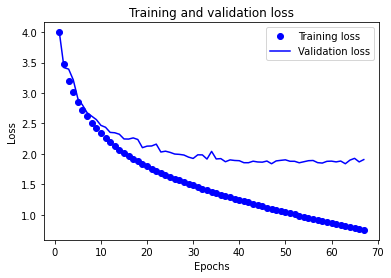

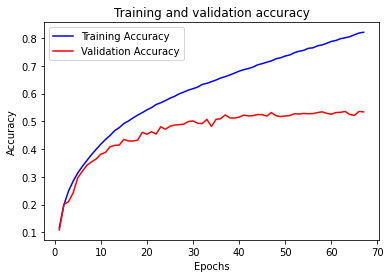

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt2.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt2.plot(epochs, test_acc, color = 'red', label='Validation Accuracy')
plt2.title('Training and validation accuracy')
plt2.xlabel('Epochs')
plt2.ylabel('Accuracy')
plt2.legend()

plt2.show()

In [ ]:
y_pred = model.predict(x_test).argmax(-1)
import sklearn.metrics as metrics
print(metrics.classification_report(y_test.argmax(axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       100
           1       0.68      0.67      0.68       100
           2       0.55      0.38      0.45       100
           3       0.38      0.36      0.37       100
           4       0.32      0.38      0.35       100
           5       0.50      0.52      0.51       100
           6       0.50      0.64      0.56       100
           7       0.58      0.60      0.59       100
           8       0.76      0.52      0.62       100
           9       0.64      0.67      0.66       100
          10       0.45      0.44      0.44       100
          11       0.42      0.40      0.41       100
          12       0.55      0.64      0.59       100
          13       0.53      0.52      0.52       100
          14       0.56      0.41      0.47       100
          15       0.43      0.43      0.43       100
          16       0.64      0.55      0.59       100
          17       0.65    

TESTS

In [17]:
model.load_weights(filepath=F"/content/gdrive/My Drive/Checkpoints/ResNet18_SGD_BatchNormalization.h5")
# model.load_weights("ResNet18_ADAM_Dropout.h5")

In [18]:
result = model.evaluate(batch_size=128, x=x_test, y=y_test)
dict(zip(model.metrics_names,result))

79/79 [==============================] - 1s 12ms/step - loss: 1.9082 - accuracy: 0.5337


{'accuracy': 0.5336999893188477, 'loss': 1.9081732034683228}